In [1]:
import numpy as np
import pandas as pd
import root_pandas as rp
import uproot as ur
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ROOT
import analysis
import array
import matplotlib
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
matplotlib.rcParams['text.usetex'] = False

Welcome to JupyROOT 6.22/02


In [2]:
a = analysis.analysis(E_cut = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}, recoils_only = True, fei4_restrict = False)

In [3]:
LER_cont_inj = a.get_tpc_data_during_study_period("LER", "Cont_inj")
LER_decay = a.get_tpc_data_during_study_period("LER", "Decay")
HER_cont_inj = a.get_tpc_data_during_study_period("HER", "Cont_inj")
HER_decay = a.get_tpc_data_during_study_period("HER", "Decay")
Lumi_cont_inj = a.get_tpc_data_during_study_period("Lumi", "Cont_inj")
Lumi_decay = a.get_tpc_data_during_study_period("Lumi", "Decay")
Lumi = {}
HER = {}
LER = {}
Single_beam = {}
Lumi_all = {}
HER_all = {}
LER_all = {}
Single_beam_all = {}
data = {} #ALL DATA TOGETHER FOR CALIBRATION

MC = a.MC_data

for tpc in Lumi_decay.keys():
    Lumi_all[tpc] = Lumi_decay[tpc].append(Lumi_cont_inj[tpc])
    HER_all[tpc] = HER_decay[tpc].append(HER_cont_inj[tpc])
    LER_all[tpc] = LER_decay[tpc].append(LER_cont_inj[tpc])
    Single_beam_all[tpc] = LER_all[tpc].append(HER_all[tpc])
    data[tpc] = Lumi_all[tpc].append(Single_beam_all[tpc])
    
    Lumi[tpc] = Lumi_cont_inj[tpc]
    HER[tpc] = HER_cont_inj[tpc]
    LER[tpc] = LER_cont_inj[tpc]
    Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    #Lumi[tpc] = Lumi_decay[tpc]
    #HER[tpc] = HER_decay[tpc]
    #LER[tpc] = LER_decay[tpc]
    #Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]
    Single_beam[tpc].index = [i for i in range(0,len(Single_beam[tpc]))]
    data[tpc].index = [i for i in range(0,len(data[tpc]))]
    #MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)]

# Check for mesh alphas

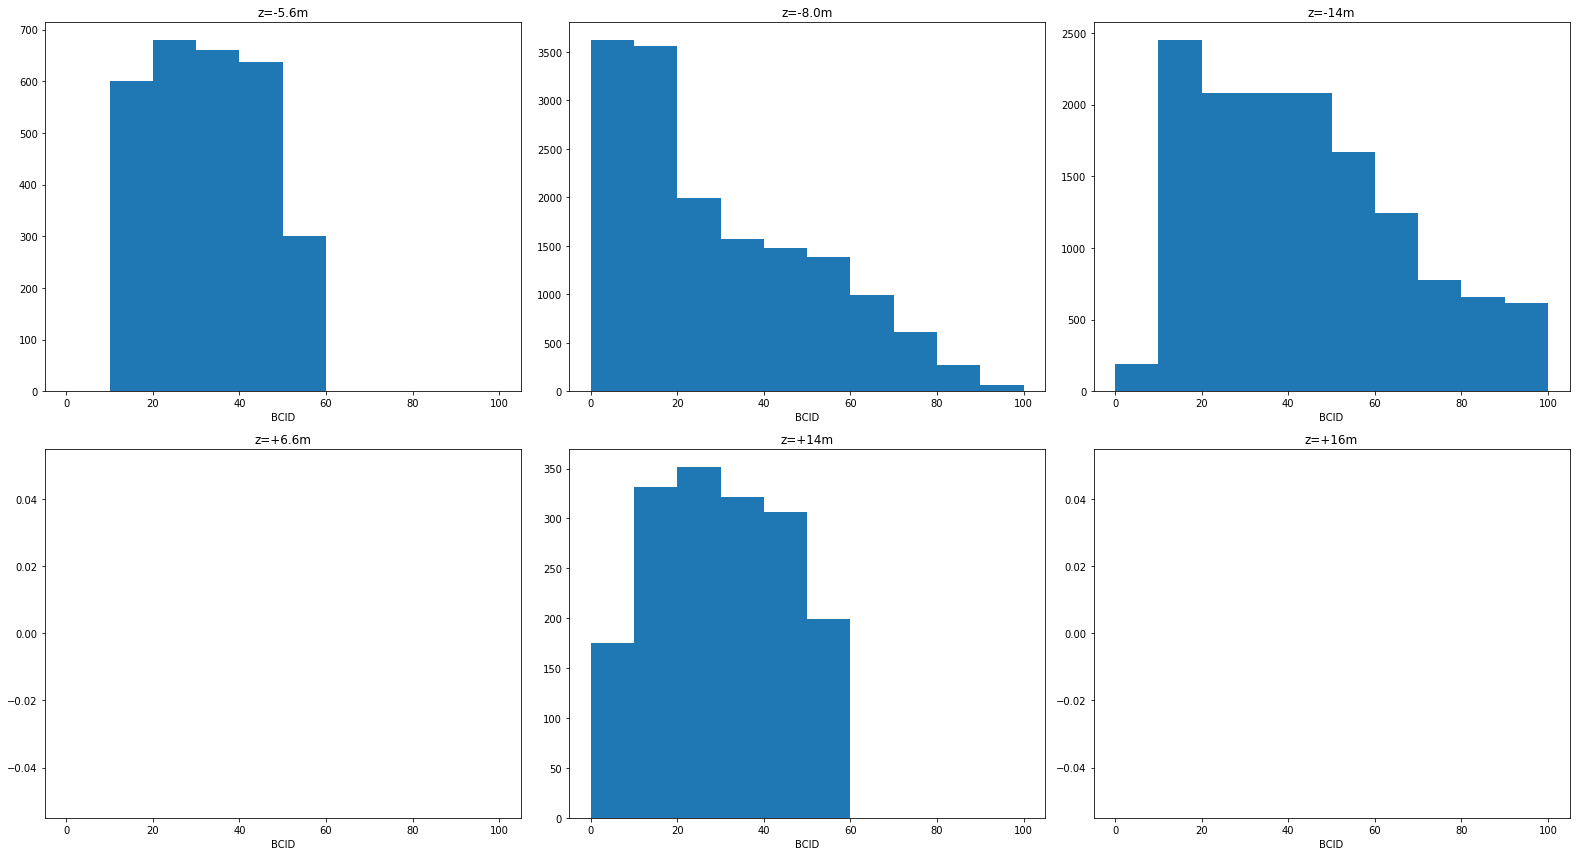

In [4]:
i=1
plt.figure(figsize=(22,12))
pos = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']
for tpc in ['palila','tako','elepaio','iiwi','nene','humu']:
    plt.subplot(2,3,i)
    try:
        lumi_tmp = np.concatenate(Lumi[tpc].loc[Lumi[tpc]['track_energy']>1200]['BCID'].to_numpy()).ravel()
    except:
        lumi_tmp = np.nan
    plt.title(pos[i-1])
    plt.hist(lumi_tmp,range=(0,100))
    plt.xlabel('BCID')
    i+=1
plt.tight_layout()

### Remove mesh alphas

In [5]:
for tpc in Lumi.keys():
    Lumi[tpc]['BCID_diff'] = Lumi[tpc]['BCID'].apply(lambda x: x.max())-Lumi[tpc]['BCID'].apply(lambda x: x.min())
    print(tpc, Lumi[tpc]['BCID_diff'].max())

iiwi 55.0
humu 62.0
nene 65.0
tako 92.0
palila 51.0
elepaio 91.0


In [6]:
for tpc in Lumi.keys():
    Lumi[tpc]['BCID_diff'] = Lumi[tpc]['BCID'].apply(lambda x: x.max())-Lumi[tpc]['BCID'].apply(lambda x: x.min())
    Lumi[tpc] = Lumi[tpc].loc[Lumi[tpc]['BCID_diff']<80]
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]

### Scale MC to 1s Averages

In [7]:
E_cut = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}
ratio = a.compute_data_MC_ratios("Cont_inj", E_cut=E_cut)[2]
ratio = ratio.replace([np.inf, -np.inf, np.nan], 1)
#skb = a.select_study("Lumi", "Cont_inj")
Scaled_MC = {}
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
factors = {'Coulomb_LER_base' : 1/4., 'Coulomb_LER_dynamic' : 1/4., 
           'Coulomb_HER_base' : 1/40., 'Coulomb_HER_dynamic' : 1/40.,
          'Brems_LER_base' : 1/40., 'Brems_LER_dynamic' : 1/40., 
           'Brems_HER_base' : 1/400., 'Brems_HER_dynamic' : 1/400.,
          'Touschek_LER_all' : 2.5, 'Touschek_HER_all' : 0.625,
          #'RBB_Lumi' : (skb['ECL_lumi'].mean()/10000)/(25*2.2e-3), 'twoPhoton_Lumi' : 100*(skb['ECL_lumi'].mean()/10000)/25.}
           'RBB_Lumi' : 1/(9.7e-3*25), 'twoPhoton_Lumi' : 100/25}

for tpc in tpcs:
    Scaled_MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)][['reco_energy','new_theta', 'new_phi','bgType', 'VRC_id', 'new_length']]
    Scaled_MC[tpc].index = [i for i in range(0,len(Scaled_MC[tpc]))]
    Scaled_MC[tpc]['ones'] = 1
    Scaled_MC[tpc]['scaled_energy'] = 0
    Scaled_MC[tpc]['weights'] = 1
for tpc in tpcs:
    for key in factors.keys():
        index = Scaled_MC[tpc].loc[(Scaled_MC[tpc]['bgType'] == key)].index.to_numpy()
        for val in index:
            if (key == 'Coulomb_LER_base') or (key == 'Brems_LER_base'):
                wkey = 'LER_bg_base'
            elif (key == 'Coulomb_HER_base') or (key == 'Brems_HER_base'):
                wkey = 'HER_bg_base'
            elif (key == 'Coulomb_LER_dynamic') or (key == 'Brems_LER_dynamic'):
                wkey = 'LER_bg_dynamic'
            elif (key == 'Coulomb_HER_dynamic') or (key == 'Brems_HER_dynamic'):
                wkey = 'HER_bg_dynamic'
            elif key == 'Touschek_LER_all':
                wkey = 'LER_T'
            elif key == 'Touschek_HER_all':
                wkey = 'HER_T'
            else:
                wkey = 'Lumi'
            #Scaled_MC[tpc]['weights'].iloc[val] = factors[key]*(datamc.T.loc[data_MC.index == tpc])[wkey][0]
            Scaled_MC[tpc]['weights'].iloc[val] = factors[key]*(ratio.loc[ratio.index == tpc])[wkey][0]
            #Scaled_MC[tpc]['reco_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            #Scaled_MC[tpc]['scaled_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            #Scaled_MC[tpc]['scaled_energy'].iloc[val] = Scaled_MC[tpc]['weights'].iloc[val]*Scaled_MC[tpc]['ones'].iloc[val]

 FCN=23.3691 FROM MINOS     STATUS=SUCCESSFUL    222 CALLS        1287 TOTAL
                     EDM=2.90238e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.16294e-10   6.32898e-06   2.00893e-02  -8.48189e-06
   2  p1           7.29908e-14   5.71849e-08   6.14680e-02   3.64720e-06
   3  p2           1.50027e-02   8.18925e-03  -1.25374e-06  -4.54173e-02
   4  p3           2.62609e-01   5.72335e-02   5.72335e-02   1.97492e-02
 FCN=30.5615 FROM MINOS     STATUS=SUCCESSFUL    202 CALLS        1024 TOTAL
                     EDM=5.67336e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.99999e-06   5.30638e-06   1.51382e-02   3.01795e-05
   2  p1           1.00000e-07   

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in

### Create Histograms

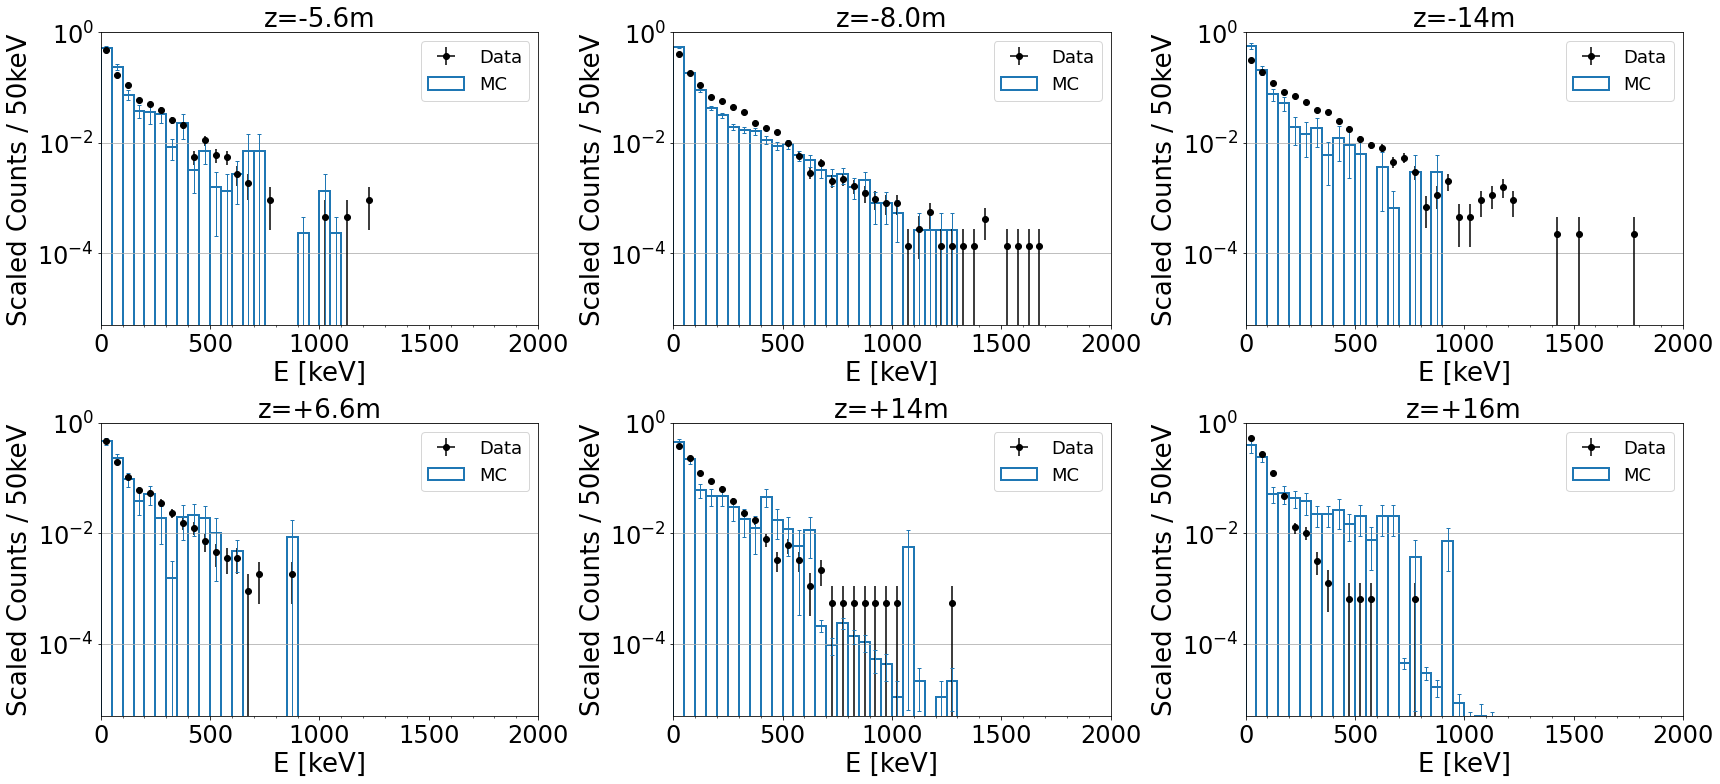

In [8]:
from matplotlib.ticker import LogFormatter

plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 41
xmin = 0
xmax = 2000
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
tpcs = ['palila', 'tako', 'elepaio','iiwi', 'nene','humu']
pos = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']#
n0 = {}
d0 = {}
p0 = {}
nerr0 = {}
derr0 = {}
err0 = {}
n1 = {}
d1 = {}
p1 = {}
nerr1 = {}
derr1 = {}
err1 = {}

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (24,11))
axs = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    test = Lumi[tpc].groupby(pd.cut(Lumi[tpc]['track_energy'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_HER = HER[tpc].groupby(pd.cut(HER[tpc]['track_energy'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_LER = LER[tpc].groupby(pd.cut(LER[tpc]['track_energy'], bins = np.linspace(xmin,xmax,nbins))).sum()
    
    ### Compute fractional coefficients for time of each background study. MC is already scaled to 1 equivalents
    foo = len(a.select_study("HER", "Cont_inj"))
    bar = len(a.select_study("LER", "Cont_inj"))
    lum = len(a.select_study("Lumi", "Cont_inj"))

    #clumi = 1/(lum) # Scale to 1s equivalent rate
    #cler = 1/(bar) # Scale to 1s equivalent rate
    #cher = 1/(foo) # Scale to 1s equivalent rate
    clumi = 1
    cler = 0
    cher = 0
    
    #plot 0: all data
    n0[tpc] = clumi*test['ones'] + cler*test_LER['ones'] + cher*test_HER['ones']
    d0[tpc] = (clumi*test['ones'] + cler*test_LER['ones'] + cher*test_HER['ones']).sum()
    nerr0[tpc] = np.sqrt(clumi**2*test['ones'] + cler**2*test_LER['ones'] + cher**2*test_HER['ones'])
    derr0[tpc] = np.sqrt((nerr0[tpc]**2).sum())
    err0[tpc] = n0[tpc]/d0[tpc]*np.sqrt((nerr0[tpc]/n0[tpc])**2+((derr0[tpc]/d0[tpc])**2))
    #err0[tpc] = nerr0[tpc]/d0[tpc]
    #p0[tpc] = axs[i-1].bar(center,n0[tpc]/d0[tpc] ,yerr = err0[tpc], width = width, label = 'All data', fc = 'None', ec = 'tab:blue',lw=2, error_kw=dict(ecolor='tab:blue', lw=1, capsize=2, capthick=1))
    #p0[tpc] = axs[i-1].bar(center,n0[tpc]/d0[tpc] ,yerr = err0[tpc], width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=2, error_kw=dict(ecolor='tab:blue', lw=1, capsize=2, capthick=1))
    p0[tpc] = axs[i-1].errorbar(center,n0[tpc]/d0[tpc] ,err0[tpc], [0 for i in range(0,len(n0[tpc]))], 'o', label = 'Data', color = 'k')
    def get_MC_weights_and_errs(df = Scaled_MC[tpc], nbins = nbins, xmin = xmin, xmax = xmax):
        spacing = (xmax-xmin)/(nbins-1)
        npoints = int((xmax-xmin)/spacing)
        boundaries = np.linspace(xmin,xmax, npoints+1)
        errs = []
        weights_list = []
        for i in range(1,len(boundaries)):
            weights = df.loc[(df['reco_energy']>boundaries[i-1]) & (df['reco_energy']<=boundaries[i])]['weights']
            errs.append(np.sqrt((weights**2).sum())) #indices are actual weights..."weights" represents number of events with each assigned weight
            weights_list.append(weights.sum())
        return pd.Series(weights_list), pd.Series(errs)

    n1[tpc] = get_MC_weights_and_errs(df = Scaled_MC[tpc])[0]
    d1[tpc] = n1[tpc].sum()
    nerr1[tpc] = get_MC_weights_and_errs(df = Scaled_MC[tpc])[1]
    derr1[tpc] = np.sqrt((nerr1[tpc]**2).sum())
    err1[tpc] = n1[tpc]/d1[tpc]*np.sqrt((nerr1[tpc]/n1[tpc])**2+((derr1[tpc]/d1[tpc])**2))
    #err1[tpc] = nerr1[tpc]/d1[tpc]
    p1[tpc] = axs[i-1].bar(center,n1[tpc]/d1[tpc],yerr=err1[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:blue',lw=2, error_kw=dict(ecolor='tab:blue', lw=1, capsize=2, capthick=1))
    
    axs[i-1].set_ylabel(r'Scaled Counts / 50keV')
    axs[i-1].set_xlabel(r'E [keV]')
    axs[i-1].set_xlim(xmin,xmax)
    axs[i-1].set_ylim(5e-6,1)
    axs[i-1].set_yscale("log")
    axs[i-1].set_title(pos[j-1])
    axs[i-1].legend(handles = [p0[tpc],p1[tpc]],ncol=1)
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].grid(axis='y', which = 'both')
    
    j+=1
    i+=1
plt.tight_layout()
plt.savefig("test.jpg", bbox_inches = 'tight', dpi = 200)
plt.show()


In [ ]:
def plot_spectra(side = "BWD", ekey = 'track_energy', combined_data = True):
    if side == "BWD":
        tpcs = ['palila', 'tako', 'elepaio', 'iiwi', 'nene', 'humu']
        locations = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']
        ring = "HER"
    else:
        tpcs = ['humu', 'nene', 'iiwi']
        ring = "LER"
        
    i = 1
    fig = plt.figure(figsize=(24,12))
    plt.rc('legend', fontsize=18)
    plt.rc('xtick', labelsize=26)
    plt.rc('ytick', labelsize=26)
    plt.rc('axes', labelsize=30)
    plt.rc('axes', titlesize=30)
    
    if combined_data == True:
        combined_data = {}
        for tpc in tpcs:
            plt.subplot(2,3,i)
            HER_cont_inj[tpc] = HER_cont_inj[tpc].append(LER_cont_inj[tpc])
            combined_data[tpc] = Lumi_cont_inj[tpc].append(HER_cont_inj[tpc])
            combined_data[tpc].index = [i for i in range(0,len(combined_data[tpc]))]
            x_plt = np.linspace(0,2000,2001)
            #plt.subplot(3,1,i)
            (counts, bins) = np.histogram(MC[tpc]['reco_energy'], bins=100, range = (0,2000))
            factor_MC = 1/len(MC[tpc]['reco_energy'])
            plt.hist(bins[:-1], bins, weights=factor_MC*counts, histtype = 'step', range = (0,2000), label = 'MC', linewidth = 2, color ='tab:orange')
            (counts, bins) = np.histogram(combined_data[tpc][ekey], bins=100, range = (0,2000))
            factor = 1/len(combined_data[tpc][ekey])
            plt.hist(bins[:-1], bins, weights=factor*counts, histtype = 'step', range = (0,2000), label = 'Data', linewidth = 2, color ='tab:blue')
            
            #plt.hist(MC[tpc]['reco_energy'], bins = 100, histtype = 'step', range = (0,2000), label = 'MC', linewidth = 2, color ='tab:orange')
            #plt.hist(combined_data[tpc][ekey], bins = 100, histtype = 'step', range = (0,2000), label = 'Data', linewidth = 2, color = 'tab:blue')
            
            params_data, errs_data = get_fit_function(combined_data[tpc], ekey)
            params_MC, errs_MC = get_fit_function(MC[tpc], 'reco_energy')
            plt.fill_between(x_plt, factor_MC*(params_MC[0]-errs_MC[0])*np.exp((params_MC[1]-errs_MC[1])*x_plt), factor_MC*(params_MC[0]+errs_MC[0])*np.exp((params_MC[1]+errs_MC[1])*x_plt), color = 'tab:orange', alpha = 0.5, label = "MC Fit")#, label = r'MC fit region: $\lambda$ = %s'%(float('%.2g' % params_MC[1])), alpha = 0.3)#, float('%.1g' % errs_MC[1])), alpha = 0.3)
            plt.fill_between(x_plt, factor*(params_data[0]-errs_data[0])*np.exp((params_data[1]-errs_data[1])*x_plt), factor*(params_data[0]+errs_data[0])*np.exp((params_data[1]+errs_data[1])*x_plt), color = 'tab:blue', alpha = 0.5, label = "Fit")#, label = r'Data fit region: $\lambda$ = %s'%(float('%.2g' % params_data[1])), alpha = 0.3)#, float('%.1g' % errs_data[1])), alpha = 0.3)
            plt.title(locations[i-1])
            plt.yscale("Log")
            plt.xlabel('Recoil Energy [keV]')
            plt.ylim(6e-5,1)
            plt.ylabel('Normalized Counts')
            plt.yticks([1e-4,1e-3,1e-2,1e-1,1])
            plt.legend()
            i+=1
    else:    
        for tpc in tpcs:
            x_plt = np.linspace(0,2000,2001)
            #plt.subplot(3,2,i)
            plt.subplot(3,1,i)
            plt.hist(MC[tpc]['reco_energy'], bins = 100, histtype = 'step', range = (20,2000), label = 'MC', linewidth = 2, color = 'gray')
            plt.hist(LER_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,2000), label = 'LER_cont_inj', linewidth = 2)
            params_LER, errs_LER = get_fit_function(LER_cont_inj[tpc], ekey)
            params_MC, errs_MC = get_fit_function(MC[tpc], 'reco_energy')
            if params_LER[0] < 50:
                pass
            else:
                plt.fill_between(x_plt, (params_LER[0]-errs_LER[0])*np.exp((params_LER[1]-errs_LER[1])*x_plt), (params_LER[0]+errs_LER[0])*np.exp((params_LER[1]+errs_LER[1])*x_plt), color = 'blue', label = r'LER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_LER[1]), float('%.2g' % errs_LER[1])), alpha = 0.3)
            plt.fill_between(x_plt, (params_MC[0]-errs_MC[0])*np.exp((params_MC[1]-errs_MC[1])*x_plt), (params_MC[0]+errs_MC[0])*np.exp((params_MC[1]+errs_MC[1])*x_plt), color = 'gray', label = r'MC fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_MC[1]), float('%.2g' % errs_MC[1])), alpha = 0.3)
            plt.hist(HER_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,2000), label = 'HER_cont_inj', linewidth = 2)
            params, errs = get_fit_function(HER_cont_inj[tpc], ekey)
            if params[0] < 50:
                pass
            else:
                plt.fill_between(x_plt, (params[0]-errs[0])*np.exp((params[1]-errs[1])*x_plt), (params[0]+errs[0])*np.exp((params[1]+errs[1])*x_plt), color = 'orange', label = r'HER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params[1]), float('%.2g' % errs[1])), alpha = 0.3)
            plt.hist(Lumi_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,2000), label = 'Lumi_cont_inj', linewidth = 2)
            params_lumi, errs_lumi = get_fit_function(Lumi_cont_inj[tpc], ekey)
            plt.fill_between(x_plt, (params_lumi[0]-errs_lumi[0])*np.exp((params_lumi[1]-errs_lumi[1])*x_plt), (params_lumi[0]+errs_lumi[0])*np.exp((params_lumi[1]+errs_lumi[1])*x_plt), color = 'green', label = r'Lumi fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_lumi[1]), float('%.2g' % errs_lumi[1])), alpha = 0.3)
            if side == "BWD":
                plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{%s} = %s$'%(ring, float('%.2g' % (params_lumi[1]-params[1]))))#, float('%.1g' % np.sqrt(errs_lumi[1]**2+errs[1]**2))), color = 'white')
            else:
                plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{%s} = %s$'%(ring, float('%.2g' % (params_lumi[1]-params_LER[1]))))#, float('%.1g' % np.sqrt(errs_lumi[1]**2+errs_LER[1]**2))), color = 'white')
            plt.title(tpc)
            #plt.yscale("Log")
            plt.xlabel('Recoil Energy [keV]')
            plt.ylabel('Rates/20keV')
            plt.ylim(0,1)
            plt.legend()
        
            #plt.subplot(3,2,i+1)
            #plt.hist(LER_decay[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'LER_decay', linewidth = 2)
            #params_LER, errs_LER = get_fit_function(LER_cont_inj[tpc], ekey)
            #if params_LER[0] < 10:
            #    pass
            #else:
            #    plt.fill_between(x_plt, (params_LER[0]-errs_LER[0])*np.exp((params_LER[1]-errs_LER[1])*x_plt), (params_LER[0]+errs_LER[0])*np.exp((params_LER[1]+errs_LER[1])*x_plt), color = 'blue', label = r'LER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_LER[1]), float('%.2g' % errs_LER[1])), alpha = 0.3)
            #plt.hist(HER_decay[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'HER_decay', linewidth = 2)
            #params, errs = get_fit_function(HER_cont_inj[tpc], ekey)
            #if params[0] < 10:
            #    pass
            #else:
            #    plt.fill_between(x_plt, (params[0]-errs[0])*np.exp((params[1]-errs[1])*x_plt), (params[0]+errs[0])*np.exp((params[1]+errs[1])*x_plt), color = 'orange', label = r'HER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params[1]), float('%.2g' % errs[1])), alpha = 0.3)
            #plt.hist(Lumi_decay[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'Lumi_decay', linewidth = 2)
            #params_lumi, errs_lumi = get_fit_function(Lumi_decay[tpc], ekey)
            #plt.fill_between(x_plt, (params_lumi[0]-errs_lumi[0])*np.exp((params_lumi[1]-errs_lumi[1])*x_plt), (params_lumi[0]+errs_lumi[0])*np.exp((params_lumi[1]+errs_lumi[1])*x_plt), color = 'green', label = r'Lumi fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_lumi[1]), float('%.2g' % errs_lumi[1])), alpha = 0.3)
            #if side == "BWD":
            #    plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{%s} = %s \pm %s$'%(ring, float('%.3g' % (params_lumi[1]-params[1])), float('%.2g' % np.sqrt(errs_lumi[1]**2+errs[1]**2))), color = 'white')
            #else:
            #    plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{%s} = %s \pm %s$'%(ring, float('%.3g' % (params_lumi[1]-params_LER[1])), float('%.2g' % np.sqrt(errs_lumi[1]**2+errs_LER[1]**2))), color = 'white')
            #plt.title(tpc)
            #plt.yscale("Log")
            #plt.xlabel('Recoil Energy [keV]')
            #plt.ylim(0.9,3000)
            #plt.legend()
            #i+=2
            i += 1
    plt.tight_layout()
    plt.savefig('spectra_data-MC.jpg')
    plt.show()
    return combined_data
def get_fit_function(df, ekey):
    h = ROOT.TH1D("h", "", 100, 20, 2000)
    energy = array.array('d', df[ekey])
    for i in range(0,len(df)):
        h.Fill(energy[i])
    f = ROOT.TF1("f","[0]*TMath::Exp(([1]*x))")
    #f.SetParLimits(0,0,20)
    #f.SetParLimits(2,0,0.001)
    f.SetParLimits(1,-0.05,0)
    h.Fit(f, "SL")
    c = ROOT.TCanvas("c1", "c1", 800, 600)
    params = f.GetParameters()
    par_errs = f.GetParErrors()
    return params, par_errs
combined_data = plot_spectra()
#params, errs = get_fit_function(Lumi_cont_inj['elepaio'])

In [ ]:
tpcs = LER_cont_inj.keys()
for tpc in tpcs:
    #plt.plot(combined_data[tpc]['new_length'], combined_data[tpc]['track_energy'],'o')
    plt.plot(MC[tpc]['new_length'],MC[tpc]['reco_energy'],'o')

In [ ]:
for tpc in MC.keys():
    for type in MC[tpc]['bgType'].unique():
        print(tpc, type, len(MC[tpc].loc[MC[tpc]['bgType']==type]))

In [ ]:
combined_data = plot_spectra("FWD")

In [ ]:
for tpc in ['humu']:
    tmp = pd.DataFrame()
    tmp = tmp.append(MC[tpc])
tmp.index = [i for i in range(0,len(tmp))]
MC_full = tmp
x_plt = np.linspace(0,2000,2001)
plt.hist(MC_full['truth_energy'], bins = 100, histtype = 'step', range = (20,2000), label = 'Truth spectrum', linewidth = 2, color ='tab:orange')
plt.hist(MC_full['reco_energy'], bins = 100, histtype = 'step', range = (20,2000), label = 'Recoil spectrum', linewidth = 2, color = 'tab:blue')
#plt.hist(MC_full['ionization_energy'], bins = 100, histtype = 'step', range = (20,2000), label = 'Ionization spectrum', linewidth = 2, color = 'tab:green')
params_data, errs_data = get_fit_function(MC_full, 'reco_energy')
params_MC, errs_MC = get_fit_function(MC_full, 'truth_energy')
#plt.fill_between(x_plt, (params_MC[0]-errs_MC[0])*np.exp((params_MC[1]-errs_MC[1])*x_plt), (params_MC[0]+errs_MC[0])*np.exp((params_MC[1]+errs_MC[1])*x_plt), color = 'tab:orange', label = r'MC truth: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_MC[1]), float('%.2g' % errs_MC[1])), alpha = 0.3)
#plt.fill_between(x_plt, (params_data[0]-errs_data[0])*np.exp((params_data[1]-errs_data[1])*x_plt), (params_data[0]+errs_data[0])*np.exp((params_data[1]+errs_data[1])*x_plt), color = 'tab:blue', label = r'MC reco: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_data[1]), float('%.2g' % errs_data[1])), alpha = 0.3)
plt.title(tpc)
#plt.yscale("Log")
plt.xlabel('Recoil Energy [keV]')
plt.ylim(0.9,120)
plt.legend()

In [ ]:
MC_full.columns

In [ ]:
def plot_spectra_all(ekey = 'full_corrected_energy'):
    tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    i = 1
    fig = plt.figure(figsize=(14,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:
        x_plt = np.linspace(0,5000,5001)
        plt.subplot(3,2,i)
        plt.hist(LER_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'LER_cont_inj', linewidth = 2)
        plt.hist(HER_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'HER_cont_inj', linewidth = 2)
        plt.hist(Lumi_cont_inj[tpc][ekey], bins = 100, histtype = 'step', range = (20,5000), label = 'Lumi_cont_inj', linewidth = 2)
        params_lumi, errs_lumi = get_fit_function(Lumi_cont_inj[tpc], ekey)
        if i%2 != 0:
            params, errs = get_fit_function(HER_cont_inj[tpc], ekey)
            if params[0] < 10:
                pass
            else:
                plt.fill_between(x_plt, (params[0]-errs[0])*np.exp((params[1]-errs[1])*x_plt), (params[0]+errs[0])*np.exp((params[1]+errs[1])*x_plt), color = 'orange', label = r'HER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params[1]), float('%.2g' % errs[1])), alpha = 0.3)
        else:
            params, errs = get_fit_function(LER_cont_inj[tpc], ekey)
            if params[0] < 10:
                pass
            else:
                plt.fill_between(x_plt, (params[0]-errs[0])*np.exp((params[1]-errs[1])*x_plt), (params[0]+errs[0])*np.exp((params[1]+errs[1])*x_plt), color = 'blue', label = r'LER fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params[1]), float('%.2g' % errs[1])), alpha = 0.3)
        
        
        plt.fill_between(x_plt, (params_lumi[0]-errs_lumi[0])*np.exp((params_lumi[1]-errs_lumi[1])*x_plt), (params_lumi[0]+errs_lumi[0])*np.exp((params_lumi[1]+errs_lumi[1])*x_plt), color = 'green', label = r'Lumi fit region: $\lambda$ = %s $\pm$ %s'%(float('%.3g' % params_lumi[1]), float('%.2g' % errs_lumi[1])), alpha = 0.3)
        if i%2 != 0:
            plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{HER} = %s \pm %s$'%(float('%.3g' % (params_lumi[1]-params[1])), float('%.2g' % np.sqrt(errs_lumi[1]**2+errs[1]**2))), color = 'white')
        else:
            plt.fill_between([0],[0],[0], lw = 0, label = r'$\lambda_{lumi}-\lambda_{LER} = %s \pm %s$'%(float('%.3g' % (params_lumi[1]-params[1])), float('%.2g' % np.sqrt(errs_lumi[1]**2+errs[1]**2))), color = 'white')
        plt.title(tpc)
        plt.yscale("Log")
        plt.xlabel('Recoil Energy [keV]')
        plt.ylim(0.9,3000)
        plt.grid()
        plt.legend()
        i += 1
    plt.tight_layout()
    plt.savefig("energy_spectra.png")
    plt.show()
def get_fit_function(df, ekey):
    h = ROOT.TH1D("h", "", 100, 20, 5000)
    energy = array.array('d', df[ekey])
    for i in range(0,len(df)):
        h.Fill(energy[i])
    f = ROOT.TF1("f","[0]*TMath::Exp(([1]*x))")
    #f.SetParLimits(0,0,20)
    #f.SetParLimits(2,0,0.001)
    f.SetParLimits(1,-0.05,0)
    h.Fit(f, "SLEM")
    c = ROOT.TCanvas("c1", "c1", 800, 600)
    params = f.GetParameters()
    par_errs = f.GetParErrors()
    return params, par_errs
plot_spectra_all()
#params, errs = get_fit_function(Lumi_cont_inj['elepaio'])

In [ ]:
def plot_He_vs_CO_spectra(side = "BWD"):
    if side == "BWD":
        tpcs = ['tako', 'palila', 'elepaio']
    else:
        tpcs = ['iiwi', 'nene', 'humu']
    i = 1
    fig = plt.figure(figsize=(10,10))
    Single_beam_cont_inj = {}
    Single_beam_decay = {}
    Single_beam_total = {}
    Single_beam_He = {}
    Single_beam_CO = {}
    Lumi_total = {}
    Lumi_He = {}
    Lumi_CO = {}
    for tpc in tpcs:
        plt.subplot(3,1,i)
        Single_beam_cont_inj[tpc] = LER_cont_inj[tpc].append(HER_cont_inj[tpc])
        Single_beam_decay[tpc] = LER_decay[tpc].append(HER_decay[tpc])
        Single_beam_total[tpc] = Single_beam_cont_inj[tpc].append(Single_beam_decay[tpc])
        Lumi_total[tpc] = Lumi_cont_inj[tpc].append(Lumi_decay[tpc])
        Lumi_He[tpc] = Lumi_total[tpc].loc[Lumi_total[tpc]['He_recoil']==1]
        Lumi_CO[tpc] = Lumi_total[tpc].loc[Lumi_total[tpc]['He_recoil']==0]
        Single_beam_He[tpc] = Single_beam_total[tpc].loc[Single_beam_total[tpc]['He_recoil']==1]
        Single_beam_CO[tpc] = Single_beam_total[tpc].loc[Single_beam_total[tpc]['He_recoil']==0]
        plt.hist(Single_beam_He[tpc]['full_corrected_energy'], bins = 100, histtype = 'step', range = (20,5000), label = 'Single beam He recoils', linewidth = 2)
        plt.hist(Single_beam_CO[tpc]['full_corrected_energy'], bins = 100, histtype = 'step', range = (20,5000), label = 'Single beam C/O recoils', linewidth = 2)
        plt.hist(Lumi_He[tpc]['full_corrected_energy'], bins = 100, histtype = 'step', range = (20,5000), label = 'Lumi He recoils', linewidth = 2)
        plt.hist(Lumi_CO[tpc]['full_corrected_energy'], bins = 100, histtype = 'step', range = (20,5000), label = 'Lumi C/O recoils', linewidth = 2)
        plt.title(tpc)
        plt.yscale("Log")
        plt.xlabel('Recoil Energy [keV]')
        plt.ylim(0.9,5000)
        plt.legend()
        i+=1
    plt.tight_layout()
    plt.show()
plot_He_vs_CO_spectra()

In [ ]:
plot_He_vs_CO_spectra(side = 'FWD')

### Redefine head-tail before doing angular analysis and transform TPC coordinate systems to Belle Frame

Transformations are below and important!

In [ ]:
### Define x, y, and z in the Belle Frame
for tpc in ['humu', 'nene', 'tako', 'elepaio', 'iiwi', 'palila']:
    for df in [Lumi_decay[tpc],Lumi_cont_inj[tpc], LER_decay[tpc],LER_cont_inj[tpc], HER_decay[tpc],HER_cont_inj[tpc]]:
        if tpc == 'nene':
            zscale = 1401.1e4
        if tpc == 'humu':
            zscale = 1601.1e4
        if tpc == 'tako':
            zscale = -798.8e4
        if tpc == 'elepaio':
            zscale = -1398.8e4
        if tpc == 'iiwi':
            zscale = 655.3e4
        if tpc == 'palila':
            zscale = -563.7e4
        if (tpc == 'humu') or (tpc == 'nene'):
            df['x_belle'] = (-df['y']+1.68e4) + 201e4
            df['y_belle'] = (df['x']+16e4)
            df['z_belle'] = df['z']+zscale
        elif (tpc == 'tako') or (tpc == 'elepaio'):
            df['x_belle'] = (-df['y']+1.68e4) + 204e4
            df['y_belle'] = (df['x']+16e4)
            df['z_belle'] = df['z']+zscale
        elif tpc == 'iiwi':
            df['x_belle'] = -182.9e4 + df['y']
            df['y_belle'] = df['x'] + 16e4
            df['z_belle'] = zscale - df['z']
        else:
            df['x_belle'] = -181.4e4 + df['y']
            df['y_belle'] = df['x'] + 16e4
            df['z_belle'] = zscale + df['z']
        

In [ ]:
from ROOT import TVector3
def fit_track(df, i): #faster than root fit, so this is standard
    x = df['x_belle'].iloc[i]
    y = df['y_belle'].iloc[i]
    z = df['z_belle'].iloc[i]
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis = 0)
    uu, dd, vv = np.linalg.svd(data-datamean)
    xhat = TVector3(vv[0][0],vv[0][1],vv[0][2])
    zhat = TVector3(0,0,1)
    yhat = zhat.Cross(xhat).Unit()
    zhat_track = xhat.Cross(yhat).Unit()
    zhat = np.array([zhat.x(), zhat.y(), zhat.z()])
    yhat = np.array([yhat.x(), yhat.y(), yhat.z()])
    x_rel = x-x.mean()
    y_rel = y-y.mean()
    z_rel = z-z.mean()
    x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(x))],[vv[0][0],vv[0][1],vv[0][2]])
    y_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(y))],yhat)
    z_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(z))],zhat)
    length = (x_track.max() - x_track.min())
    width = (y_track.max() - y_track.min())
    projection= []
    for point in data:
        projection += [np.dot(point, vv[0])]
    #projection = x_track
    maxp = max(projection)
    minp = min(projection)
    midp = 0.5*float(maxp+minp)
    head_charge = 0
    tail_charge = 0
    head_q = 0
    tail_q = 0
    phi_no_headtail = xhat.Phi()*180/np.pi
    for p in projection:
        if p > midp:
            head_charge += 1
            head_q += 1
        else:
            tail_charge += 1
            tail_q += 1
    if head_charge > tail_charge:
        xhat = -1. * xhat
    head_charge_fraction = head_charge/(head_charge+tail_charge)
    tail_charge_fraction = 1 - head_charge_fraction
    theta = xhat.Theta()*180/np.pi
    phi = xhat.Phi()*180/np.pi
    return theta, phi, phi_no_headtail, head_charge_fraction, tail_charge_fraction
tpcs = Lumi_decay.keys()

for tpc in ['humu','nene', 'tako', 'elepaio', 'iiwi', 'palila']:
    for df in [Lumi_decay[tpc],Lumi_cont_inj[tpc], LER_decay[tpc],LER_cont_inj[tpc], HER_decay[tpc],HER_cont_inj[tpc]]:
        theta_belle = []
        phi_belle = []
        phi_before_headtail_belle = []
        hq = []
        tq = []
        for i in range(0,len(df)):
            theta_b, phi_b, phi_b_no_ht, headq, tailq = fit_track(df, i)
            theta_belle.append(theta_b)
            phi_belle.append(phi_b)
            phi_before_headtail_belle.append(phi_b_no_ht)
            hq.append(headq)
            tq.append(tailq)
        df['theta_belle'] = theta_belle
        df['phi_belle'] = phi_belle
        df['phi_belle_no_headtail'] = phi_before_headtail_belle
        df['head_charge_original'] = hq
        df['tail_charge_original'] = tq


In [ ]:
plt.plot(Lumi_cont_inj['tako']['phi'], Lumi_cont_inj['tako']['phi_belle'], 'o')
plt.xlabel('phi')
plt.ylabel('phi_belle')
plt.ylim(-180,180)
plt.xlim(-180,180)
Lumi_cont_inj['tako']['phi']+180, Lumi_cont_inj['tako']['phi_belle']

In [ ]:
def plot_angular_dist(side = "BWD"):
    if side == "BWD":
        tpcs = ['tako', 'palila', 'elepaio']
    else:
        tpcs = ['iiwi', 'nene', 'humu']
    i = 1
    fig = plt.figure(figsize=(10,12))
    '''
    for tpc in tpcs:
        plt.subplot(3,2,i)
        plt.hist(LER_cont_inj[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'LER_cont_inj', linewidth = 2)
        plt.hist(HER_cont_inj[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'HER_cont_inj', linewidth = 2)
        plt.hist(Lumi_cont_inj[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'Lumi_cont_inj', linewidth = 2)
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('cos(theta)')
        #plt.ylim(0,350)
        plt.legend(loc = 'upper left')
        plt.subplot(3,2,i+1)
        plt.hist(LER_decay[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'LER_decay', linewidth = 2)
        plt.hist(HER_decay[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'HER_decay', linewidth = 2)
        plt.hist(Lumi_decay[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'Lumi_decay', linewidth = 2)
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track theta [degrees]')
        #plt.ylim(0,350)
        plt.legend(loc = 'upper left')
        i+=2
    '''
    for tpc in tpcs:
        plt.subplot(3,2,i)
        plt.hist(combined_data[tpc]['theta'], bins = 60, histtype = 'step', range = (-5,185), label = 'data', linewidth = 2)
        #plt.yscale("Log")
        plt.xlabel('theta[$^\circ$]')
        plt.xticks([0,30,60,90,120,150,180])
        #plt.ylim(0,350)
        #plt.legend(loc = 'upper left')
        plt.title(tpc)
        plt.grid()
        plt.subplot(3,2,i+1)
        #plt.hist(Lumi_decay[tpc]['theta'], bins = 60, histtype = 'step', range = (0,180), label = 'Lumi_decay', linewidth = 2)
        plt.hist(combined_data[tpc]['phi'], bins = 60, histtype = 'step', range = (-5,185), label = 'data', linewidth = 2)
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xticks([0,30,60,90,120,150,180])
        plt.xlabel(r'Phi[$^\circ$]')
        #plt.ylim(0,350)
        #plt.legend(loc = 'upper left')
        plt.grid()
        i+=2
    plt.tight_layout()
    plt.show()
plot_angular_dist("BWD")

In [ ]:
plot_angular_dist("FWD")

In [ ]:
def plot_phi_dist(side = "BWD"):
    if side == "BWD":
        tpcs = ['tako', 'palila', 'elepaio']
    else:
        tpcs = ['iiwi', 'nene', 'humu']
    i = 1
    fig = plt.figure(figsize=(20,10))
    for tpc in tpcs:
        plt.subplot(3,2,i)
        plt.hist(LER_cont_inj[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'LER_cont_inj', linewidth = 2)
        plt.hist(HER_cont_inj[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'HER_cont_inj', linewidth = 2)
        plt.hist(Lumi_cont_inj[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'Lumi_cont_inj', linewidth = 2)
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track phi [degrees]')
        #plt.ylim(0.9,3000)
        plt.legend()
        plt.subplot(3,2,i+1)
        plt.hist(LER_decay[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'LER_decay', linewidth = 2)
        plt.hist(HER_decay[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'HER_decay', linewidth = 2)
        plt.hist(Lumi_decay[tpc]['phi'], bins = 90, histtype = 'step', range = (-185,185), label = 'Lumi_decay', linewidth = 2)
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track phi [degrees]')
        #plt.ylim(0.9,3000)
        plt.legend()
        i+=2
    plt.tight_layout()
    plt.show()
plot_phi_dist()

# Fold phi for angular analysis

In [ ]:
Single_beam_combined = {}
for tpc in ['elepaio', 'tako', 'palila', 'iiwi', 'nene', 'humu']:
    #combined_data[tpc]['phi_fold'] = combined_data[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    #combined_data[tpc]['phi_fold'] = combined_data[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    Lumi_cont_inj[tpc]['phi_fold'] = Lumi_cont_inj[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    Lumi_cont_inj[tpc]['phi_fold'] = Lumi_cont_inj[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    HER_cont_inj[tpc]['phi_fold'] = HER_cont_inj[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    HER_cont_inj[tpc]['phi_fold'] = HER_cont_inj[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    LER_cont_inj[tpc]['phi_fold'] = LER_cont_inj[tpc]['phi'].apply(lambda x: x if x <= 90 else 180-x)
    LER_cont_inj[tpc]['phi_fold'] = LER_cont_inj[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)
    Single_beam_combined[tpc] = HER_cont_inj[tpc].append(LER_cont_inj[tpc])
    MC[tpc]['phi_fold'] = (MC[tpc]['fit_phi']*180/np.pi).apply(lambda x: x if x <= 90 else 180-x)
    MC[tpc]['phi_fold'] = MC[tpc]['phi_fold'].apply(lambda x: x if x >= -90 else -180-x)

In [ ]:
#Lumi_cont_inj['palila'] = Lumi_cont_inj['palila'].loc[Lumi_cont_inj['palila']['track_energy']>100]
plt.figure(figsize = (14,12))
i = 1
for tpc in ['palila', 'tako', 'elepaio']:
    tmp = Lumi_cont_inj[tpc].loc[(Lumi_cont_inj[tpc]['phi_fold']<1000)]# & (Lumi_cont_inj[tpc]['phi_fold']>-1000)]
    tmp = tmp.loc[tmp['track_energy']>50]
    plt.subplot(3,2,i)
    plt.hist(np.abs(np.cos(tmp['theta']*np.pi/180)), bins = 21, range = (0,1))#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
    #plt.hist(tmp['phi_fold'], bins = 21, range = (-90,90))
    plt.xlabel(r'|cos($\theta$)|')
    plt.title(tpc)
    i+=1
plt.tight_layout()
plt.show()

In [ ]:
MC_Lumi = {}
#for tpc in ['palila', 'tako', 'elepaio']:
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    MC_Lumi[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]
    MC_Lumi[tpc] = MC_Lumi[tpc].loc[((MC_Lumi[tpc]['truth_mother_Z']>-870) & #Line is for RBB hotspot
               (MC_Lumi[tpc]['truth_mother_Z']<-750) & (MC_Lumi[tpc]['truth_mother_X']>20) &
                                       (MC_Lumi[tpc]['truth_mother_X']<60) &
                                       (np.abs(MC_Lumi[tpc]['truth_mother_Y'])<20))]

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp
MC_single = {}
i = 1
plt.figure(figsize = (14,12))
labels = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=14m', 'z=-14m', 'z=+16m']
#for tpc in ['palila', 'tako', 'elepaio']:
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    lumi_data = Lumi_cont_inj[tpc].loc[Lumi_cont_inj[tpc]['track_energy']>100]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    #lumi_data = lumi_data.loc[(lumi_data['phi_fold']<20) & (lumi_data['phi_fold']>-20)]
    single_beam_data = Single_beam_combined[tpc].loc[(Single_beam_combined[tpc]['track_energy']>100)]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    #single_beam_data = single_beam_data.loc[(single_beam_data['phi_fold']<20) & (single_beam_data['phi_fold']>-20)]
    plt.subplot(3,2,i)
    
    (counts_lumi, bins_lumi) = np.histogram(np.abs(np.cos(lumi_data['theta']*np.pi/180)), bins=51, range = (0,1))
    factor_lumi = 1/counts_lumi.max()
    plt.hist(bins_lumi[:-1], bins_lumi, weights=factor_lumi*counts_lumi, label = 'Lumi Data', histtype = 'step')
    
    (counts_sb, bins_sb) = np.histogram(np.abs(np.cos(single_beam_data['theta']*np.pi/180)), bins=51, range = (0,1))
    factor_sb = 1/counts_sb.max()
    plt.hist(bins_sb[:-1], bins_sb, weights=factor_sb*counts_sb, label = 'Single Beam Data', histtype = 'step')
                                                      
    #result = epps_singleton_2samp(np.cos(lumi_data['theta']*np.pi/180), np.cos(single_beam_data['theta']*np.pi/180))
    #print(result)
    
    plt.legend()
    plt.title(labels[i-1])
    plt.ylim(0,1.5)
    i+=1
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp
from scipy.stats import anderson_ksamp
MC_single = {}
i = 1
plt.figure(figsize = (7,12))
for tpc in ['palila', 'tako', 'elepaio']:
#for tpc in ['iiwi', 'nene', 'humu']:
    tmp = MC_Lumi[tpc].loc[MC_Lumi[tpc]['reco_energy']>50]
    MC_single[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]
    tmp2 = MC_single[tpc].loc[MC_single[tpc]['reco_energy']>50]
    #tmp_data = Single_beam_combined[tpc].loc[(Single_beam_combined[tpc]['phi_fold']<100)]# & (Single_beam_combined[tpc]['phi_fold']>-10)]# & (Lumi_cont_inj[tpc]['phi_fold']>-3)]
    tmp_data = Lumi_cont_inj[tpc].loc[(Lumi_cont_inj[tpc]['phi_fold']<50)]# & (Lumi_cont_inj[tpc]['phi_fold']>-10)]
    tmp_data = tmp_data.loc[tmp_data['track_energy']>50]
    #tmp = tmp.loc[tmp['phi_fold']<-50]
    plt.subplot(3,1,i)
    #plt.hist(np.abs(np.cos(tmp['fit_theta'])), bins = 21, range = (0,1), histtype='step', label = 'Lumi_MC')
    (counts, bins) = np.histogram(np.abs(np.cos(tmp_data['theta']*np.pi/180)), bins=41, range = (0,1))
    factor = 1/counts.max()
    plt.hist(bins[:-1], bins, weights=factor*counts, label = 'Data Lumi', histtype = 'step')
    #plt.hist(np.abs(np.cos(tmp_data['theta']*np.pi/180)), bins = 21, range = (0,1), label = 'data', histtype = 'step')
    (counts_MC, bins_MC) = np.histogram(np.abs(np.cos(tmp2['fit_theta'])), bins=41, range = (0,1))
    factor_MC = 1/counts_MC.max()
    plt.hist(bins_MC[:-1], bins_MC, weights=factor_MC*counts_MC, label = 'MC Lumi', histtype = 'step')
    #plt.hist(np.abs(np.cos(tmp2['fit_theta'])), bins = 21, range = (0,1), histtype = 'step', label = 'Single beam MC')
    #plt.hist(tmp['phi_fold'], bins = 21, range = (-180,180))
    #print(len(tmp))
    #result = ks_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    #print(result)
    result2 = ks_2samp(np.abs(np.cos(tmp2['fit_theta'])), np.abs(np.cos(tmp_data['theta']*np.pi/180)))
    #result = anderson_ksamp([np.cos(tmp['fit_theta']).to_numpy(), np.cos(tmp_data['theta']*np.pi/180).to_numpy()])
    print(result2)
    plt.legend()
    plt.title(tpc)
    plt.ylim(0,1.5)
    i+=1

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp

MC_single = {}
plt.figure(figsize = (7,12))
i = 1
for tpc in ['palila', 'tako', 'elepaio']:
    MC_single[tpc] = MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]
    tmp2 = MC_single[tpc].loc[MC_single[tpc]['reco_energy']>100]
    plt.subplot(3,1,i)
    plt.hist(np.abs(np.cos(tmp2['fit_theta'])), bins = 21, range = (0,1))
    result = ks_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    #result = epps_singleton_2samp(np.abs(np.cos(tmp['fit_theta'])), np.abs(np.cos(tmp2['fit_theta'])))
    print(len(tmp2))
    print(result)
    #plt.hist(tmp2['phi_fold'], bins = 21)
    plt.title(tpc)
    i+=1

In [ ]:
MC_Lumi['palila'].columns

In [ ]:
import matplotlib
def plot_theta_phi(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(14,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:
        #plt.subplot(6,3,i)
        #plt.hist2d(np.cos(LER_cont_inj[tpc]['theta']*np.pi/180), LER_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'LER_cont_inj', norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' LER_cont_inj')
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        plt.subplot(3,2,i+1)
        plt.hist2d(np.abs(np.cos(Lumi_cont_inj[tpc]['theta']*np.pi/180)), Lumi_cont_inj[tpc]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data', vmin = 0)#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Luminosity Study')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        plt.subplot(3,2,i)
        plt.hist2d(np.abs(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180)), Single_beam_combined[tpc]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data', vmin = 0 )#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Single Beam Combined')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        #plt.hist2d(MC[tpc]['fit_theta']*180/np.pi, MC[tpc]['fit_phi']*180/np.pi, bins = (10,10), range = ((-180,180), (-185,185)), label = 'MC')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' MC')
        #plt.colorbar()
        #plt.yscale("Log")
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        #plt.ylim(0.9,3000)
        #plt.legend()
        
        #plt.hist(LER_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'LER_decay', linewidth = 2)
        #plt.hist(HER_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'HER_decay', linewidth = 2)
        #plt.hist(Lumi_decay[tpc]['theta'], bins = 90, histtype = 'step', range = (-5,185), label = 'Lumi_decay', linewidth = 2)
        #plt.title(tpc)
        #plt.yscale("Log")
        #plt.xlabel('Track theta [degrees]')
        #plt.ylim(0.9,3000)
        #plt.legend()
        i+=2
    plt.tight_layout()
    plt.show()
plot_theta_phi('BWD')

In [ ]:
import matplotlib
def plot_theta_phi_MC(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(14,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:

        plt.subplot(3,2,i+1)
        plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] == 'RBB_Lumi') | (MC[tpc]['bgType'] == 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Lumi MC')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        plt.subplot(3,2,i)
        plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title('Single Beam MC')
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        i+=2
    plt.tight_layout()
    plt.show()
plot_theta_phi_MC('BWD')

In [ ]:
import matplotlib
def plot_theta_phi_MC(side = 'BWD'):
    #tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    if side == 'BWD':
        tpcs = ['palila', 'tako', 'elepaio']
    else:
        tpcs = ['humu', 'nene', 'iiwi']
    i = 1
    fig = plt.figure(figsize=(7,12))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:

        plt.subplot(3,1,i)
        plt.hist2d(np.abs(np.cos(MC[tpc]['fit_theta'])), MC[tpc]['phi_fold'], bins = (11,6), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.hist2d(np.cos(Single_beam_combined[tpc]['theta']*np.pi/180), Single_beam_combined[tpc]['phi_fold'], bins = (20,10), range = ((-1.1,1.1), (-95,95)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title(tpc)
        plt.xlabel(r'|cos($\theta$)|')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-90,90)
        plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        #plt.subplot(3,2,i)
        #plt.hist2d(np.abs(np.cos(MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['fit_theta'])), MC[tpc].loc[(MC[tpc]['bgType'] != 'RBB_Lumi') & (MC[tpc]['bgType'] != 'twoPhoton_Lumi')]['phi_fold'], bins = (11,9), range = ((0,1), (-90,90)), label = 'Data')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title('Single Beam MC')
        #plt.xlabel(r'|cos($\theta$)|')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-90,90)
        #plt.colorbar().set_label('Recoils/bin', rotation = 270, labelpad = 20)
        i+=1
    plt.tight_layout()
    plt.show()
plot_theta_phi_MC('BWD')

In [ ]:
MC['iiwi'].columns

In [ ]:
def plot_E_v_Theta(side = "BWD"):
    if side == "BWD":
        tpcs = ['tako', 'palila', 'elepaio']
    else:
        tpcs = ['iiwi', 'nene', 'humu']
    i = 1
    fig = plt.figure(figsize=(20,10))
    for tpc in tpcs:
        plt.subplot(3,2,i)
        plt.plot(Lumi_cont_inj[tpc]['theta'], Lumi_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'Lumi_cont_inj')
        plt.plot(LER_cont_inj[tpc]['theta'], LER_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'LER_cont_inj')
        plt.plot(HER_cont_inj[tpc]['theta'], HER_cont_inj[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'HER_cont_inj')
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track theta [degrees]')
        plt.ylabel('Energy [keV]')
        plt.ylim(0,1000)
        plt.legend()
        plt.subplot(3,2,i+1)
        plt.plot(Lumi_decay[tpc]['theta'], Lumi_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'Lumi_decay')
        plt.plot(LER_decay[tpc]['theta'], LER_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'LER_decay')
        plt.plot(HER_decay[tpc]['theta'], HER_decay[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.5, label = 'HER_decay')
        plt.title(tpc)
        #plt.yscale("Log")
        plt.xlabel('Track theta [degrees]')
        plt.ylabel('Energy [keV]')
        plt.ylim(0,1000)
        plt.legend()
        i+=2
    plt.tight_layout()
    plt.show()
plot_E_v_Theta("BWD")

In [ ]:
import matplotlib
def plot_theta_phi_paper():
    tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
    i = 1
    fig = plt.figure(figsize=(12,10))
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    for tpc in tpcs:
        #plt.subplot(6,3,i)
        #plt.hist2d(np.cos(LER_cont_inj[tpc]['theta']*np.pi/180), LER_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'LER_cont_inj', norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        #plt.title(tpc+' LER_cont_inj')
        #plt.xlabel(r'cos($\theta$)')
        #plt.ylabel(r'$\phi$ [$^\circ$]')
        #plt.ylim(-200,200)
        plt.subplot(3,2,i)
        plt.hist2d(np.cos(Lumi_cont_inj[tpc]['theta']*np.pi/180), Lumi_cont_inj[tpc]['phi'], bins = (20,15), range = ((-1.2,1.2), (-185,185)), label = 'Lumi_cont_inj')#, norm = matplotlib.colors.LogNorm(vmin=0.9, vmax=100))
        plt.title(tpc)
        plt.xlabel(r'cos($\theta$)')
        plt.ylabel(r'$\phi$ [$^\circ$]')
        plt.ylim(-200,200)
        plt.colorbar()
        i+=1
    plt.tight_layout()
    plt.savefig("ang_dist.png")
    plt.show()
plot_theta_phi_paper()